# G-Research 

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("/scratch/hteagle/ML_data/train.csv")

In [3]:
asset_details = pd.read_csv("/scratch/hteagle/ML_data/asset_details.csv")
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [4]:
def asset_index(asset_name):
    return asset_details.loc[asset_details['Asset_Name']==asset_name]["Asset_ID"].values[0]
import numpy as np
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods).rename("log_return")

In [5]:
asset_dfs = {}
for _,asset in asset_details.iterrows():
    asset_dfs[asset.Asset_Name] = df_train[df_train["Asset_ID"]==asset['Asset_ID']]
    asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].reindex(range(asset_dfs[asset.Asset_Name].index[0],asset_dfs[asset.Asset_Name].index[-1]+60,60),method='pad')
    

/tmp/ipykernel_19684/3630465153.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/user/hteagle/miniconda3/envs/ML_c/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


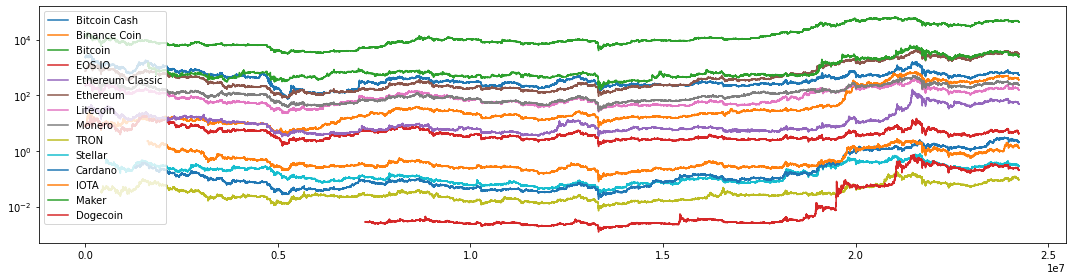

In [6]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(15,4))
for name,asset in asset_dfs.items():
    plt.plot(asset['Close'], label=name)
    
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()



In [7]:
# Convert to more useful log(%change)

log_returns = {}
for _, asset in asset_details.iterrows():
    log_returns = log_return(asset_dfs[asset.Asset_Name].Close).fillna(0)[1:]
    asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].join(log_returns, rsuffix=asset.Asset_Name, how="outer").fillna(0)
    asset_dfs[asset.Asset_Name]['Datetime'] = pd.to_datetime(asset_dfs[asset.Asset_Name]['timestamp'], unit='s')
    asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].set_index("Datetime")
    

In [8]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

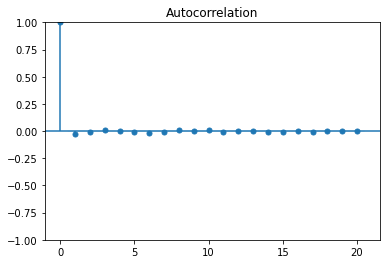

In [9]:
fig = tsaplots.plot_acf(asset_dfs["Bitcoin"]['log_return'],lags=20)
plt.show()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"]=(15,7)
def season_df_add(data, label):
    df=data.resample("d").mean()
    decomp = seasonal_decompose(df.Close, model="additive")
    decomp.plot()
    print(decomp)
    return plt.show()
def season_df_mul(data, label):
    df=data.resample("d").mean()
    decomp = seasonal_decompose(df.Close, model="multiplicative")
    decomp.plot()
    print(decomp)
    return plt.show()


In [ ]:
season_df_add(asset_dfs['Bitcoin'], label="Bitcoin")

The residuals grow with the scale of the price, therefore multiplicative decomposition might describe the data better:

In [ ]:
season_df_mul(asset_dfs['Bitcoin'], label="Bitcoin")

### Build the features as in the tutorial

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(asset_dfs['Bitcoin']))
scaler = StandardScaler()

[(array([    0,     1,     2, ..., 67325, 67326, 67327]), array([ 67328,  67329,  67330, ..., 134649, 134650, 134651])), (array([     0,      1,      2, ..., 134649, 134650, 134651]), array([134652, 134653, 134654, ..., 201973, 201974, 201975])), (array([     0,      1,      2, ..., 201973, 201974, 201975]), array([201976, 201977, 201978, ..., 269297, 269298, 269299])), (array([     0,      1,      2, ..., 269297, 269298, 269299]), array([269300, 269301, 269302, ..., 336621, 336622, 336623])), (array([     0,      1,      2, ..., 336621, 336622, 336623]), array([336624, 336625, 336626, ..., 403945, 403946, 403947]))]


In [11]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

In [12]:
inputs = []
targets = []
for name,asset in asset_dfs.items():
    asset_input = pd.concat([log_return(asset.VWAP,periods=5), log_return(asset.VWAP,periods=1).abs(), 
                   upper_shadow(asset), lower_shadow(asset)], axis=1)
    asset_input.replace([np.inf, -np.inf], np.nan, inplace=True)
    asset_input = asset_input.fillna(0)
    #print(asset_input)
    scaler.fit(asset_input)
    asset_input = scaler.transform(asset_input)
    inputs.append(asset_input)
    target = asset['Target'].fillna(method="ffill")
    targets.append(target)


/user/hteagle/miniconda3/envs/ML_c/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/user/hteagle/miniconda3/envs/ML_c/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
# Get the inputs that have the same number of entries
inputs_s = [i for i in inputs if i.shape == inputs[0].shape]
targets_s = [i for i,j in zip(targets,inputs) if j.shape == inputs[0].shape]

In [14]:
# Concatenate the series'
X = np.concatenate(inputs_s, axis=1)
y = np.column_stack(targets_s)

In [15]:
X_train = X[splits[-1][0][0]:splits[-1][0][-1]]
y_train = y[splits[-1][0][0]:splits[-1][0][-1]]
X_test  = X[splits[-1][1][0]:splits[-1][1][-1]]
y_test  = y[splits[-1][1][0]:splits[-1][1][-1]]
y_train = np.nan_to_num(y_train)

In [17]:
def weighted_correlation(a, b, weights):

    w = np.ravel(weights)
    a = np.ravel(a)
    b = np.ravel(b)

    sum_w = np.sum(w)
    mean_a = np.sum(a * w) / sum_w
    mean_b = np.sum(b * w) / sum_w
    var_a = np.sum(w * np.square(a - mean_a)) / sum_w
    var_b = np.sum(w * np.square(b - mean_b)) / sum_w

    cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return corr

In [67]:
def plot_predictions(train, train_pred, test=None, test_pred=None, plot_range=None):
    do_test=False
    if test is not None and test_pred is not None:
        do_test=True
    if plot_range is not None:
        assert type(plot_range) is tuple
        train = train[plot_range[0]:plot_range[1]]
        train_pred = train_pred[plot_range[0]:plot_range[1]]
        if do_test:
            test = test[plot_range[0]:plot_range[1]]
            test_pred = test_pred[plot_range[0]:plot_range[1]]
    if not do_test:
        for i,((_,train_col),(_,pred_col)) in enumerate(zip(train.iteritems(),train_pred.iteritems())):
            plt.plot(train_col, label='train')
            plt.plot(pred_col, label='train prediction')
            plt.legend()
            plt.show()
            print('Test score for train', f"{np.corrcoef(train_col, pred_col)[0,1]:.2f}")
    else:
        for i,((_,train_col),(_,pred_train),(_,test_col),(_,pred_test)) in enumerate(zip(train.iteritems(),train_pred.iteritems(),test.iteritems(),test_pred.iteritems())):
            plt.plot(train_col, label='train')
            plt.plot(pred_train, label='train prediction')
            plt.plot(test_col, label='test')
            plt.plot(pred_test, label='test prediction')
            plt.legend()
            plt.show()
            print('Test score for train', f"{np.corrcoef(train_col, pred_train)[0,1]:.2f}")
            print('Test score for test', f"{np.corrcoef(pred_test, test_col)[0,1]:.2f}")
    # Calculate the overall metric (for first 8 classes)
    train_weights = np.tile(asset_details['Weight'][0:8],len(train))
    train_score = weighted_correlation(train,train_pred,train_weights)
    test_weights = np.tile(asset_details['Weight'][0:8],len(test))
    test_score  = weighted_correlation(test,test_pred,test_weights)
    print("Train overall metric: %f"%(train_score))
    print("Test overall metric: %f"%(test_score))

## Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(LinearRegression())
clf.fit(X_train,y_train)


MultiOutputRegressor(estimator=LinearRegression())

In [19]:
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)

In [20]:
# Put the predictions into time series using the indices from the original dataset
btc_asset_train = asset_dfs['Bitcoin'][splits[-1][0][0]:splits[-1][0][-1]]
btc_asset_test  = asset_dfs['Bitcoin'][splits[-1][1][0]:splits[-1][1][-1]]
y_train = pd.DataFrame(data=y_train, index=btc_asset_train.index)
y_test = pd.DataFrame(data=y_test, index=btc_asset_test.index)
preds_train = pd.DataFrame(data=preds_train, index=btc_asset_train.index)
preds_test = pd.DataFrame(data=preds_test, index=btc_asset_test.index)

,0,1,2,3,4,5,6,7
Datetime,,,,,,,,
2021-03-04 14:00:00,0.000078,-0.000029,0.000008,-0.000032,-0.000008,-0.000297,-1.321442e-04,0.000149
2021-03-04 14:04:00,-0.000067,0.000066,0.000052,-0.000114,0.000260,-0.000026,-1.467465e-08,0.000305
2021-03-04 14:08:00,0.000015,-0.000086,0.000104,-0.000023,-0.000092,-0.000050,1.999167e-04,0.000153
2021-03-04 14:13:00,0.000111,-0.000031,-0.000010,0.000031,0.000061,-0.000106,1.869477e-04,0.000032
2021-03-04 14:17:00,0.000239,0.000141,-0.000054,0.000002,0.000163,-0.000164,2.629268e-04,0.000352
...,...,...,...,...,...,...,...,...
2021-09-20 23:40:00,-0.000104,0.000118,0.000120,0.000013,0.000019,-0.000066,2.130708e-04,0.000070
2021-09-20 23:44:00,-0.000003,-0.000042,0.000019,-0.000093,0.000319,-0.000220,1.449958e-04,-0.000086
2021-09-20 23:49:00,-0.000101,-0.000080,0.000072,-0.000167,0.000015,-0.000040,-1.030253e-04,0.000006


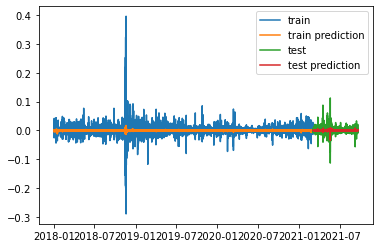

Test score for train 0.06
Test score for test 0.06


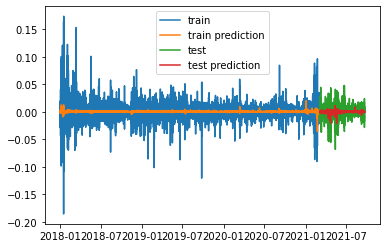

Test score for train 0.05
Test score for test 0.02


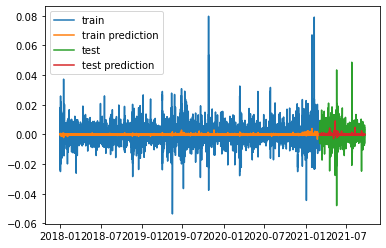

Test score for train 0.04
Test score for test 0.00


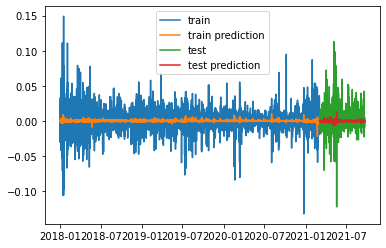

Test score for train 0.05
Test score for test -0.00


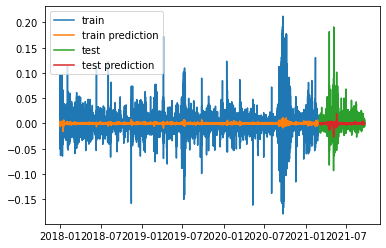

Test score for train 0.06
Test score for test 0.00


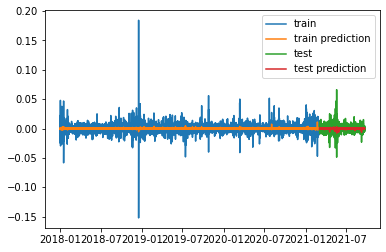

Test score for train 0.06
Test score for test 0.00


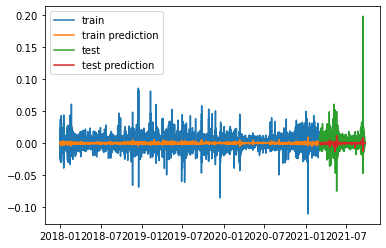

Test score for train 0.07
Test score for test 0.05


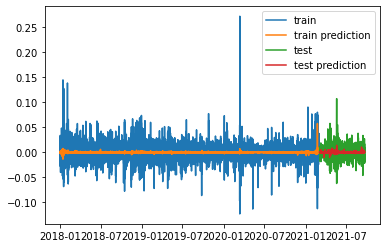

Test score for train 0.06
Test score for test -0.01
Train overall metric: 0.056811
Test overall metric: 0.012840


In [68]:
plot_predictions(y_train,preds_train,y_test,preds_test)#, plot_range=('2018-01-01','2018-02-01'))

## To Do:
* LSTM 
* GRU

0.05681134196738986